# Homework 3:  Gradients 

For this assignment, you'll need the file `grad2d.py`, which should be placed in the same directory as this notebook.

In [1]:
from grad2d import grad2d, divergence2d

Now, setup the environment with a bunch of functions you'll need.

In [2]:
# Setup the environment - do not modify this cell, but run it before anything else
import numpy as np
from numpy import sqrt, sum, abs, max, maximum, logspace, exp, log, log10, zeros
from numpy.random import randn, normal, choice
from numpy.linalg import norm
import scipy
from scipy.linalg import orth
import urllib, io
import matplotlib.pyplot as plt
np.random.seed(0)
def good_job(path):
    f = urllib.request.urlopen(path)
    a = plt.imread(io.BytesIO(f.read()))
    fig = plt.imshow(a)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

## Some useful tools
Run the following code.  

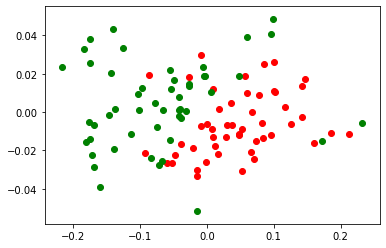

In [3]:
def buildmat(m,n,cond_number):
    """Build an mxn matrix with condition number cond."""
    if m<=n:
        U = randn(m,m);
        U = orth(U);
        Vt = randn(n, m);
        Vt = orth(Vt).T;
        S = 1/logspace(0,log10(cond_number),num=m);
        return (U*S[:,None]).dot(Vt)
    else:
        return buildmat(n,m,cond_number).T
    
def create_classification_problem(num_data, num_features, cond_number):
    """Build a simple classification problem."""
    X = buildmat(num_data, num_features, cond_number)
    # The linear dividing line between the classes
    w =  randn(num_features,1)
    # create labels
    prods = X@w
    y = np.sign(prods)
    #  mess up the labels on 10% of data
    flip = choice(range(num_data),int(num_data/10))
    y[flip] = -y[flip]
    #  return result
    return X,y
# Visualize this classification problem
X,y = create_classification_problem(100, 2, 5)
y = y.ravel()
plt.scatter(X[:,0][y>0], X[:,1][y>0], color='r')
plt.scatter(X[:,0][y<0], X[:,1][y<0], color='g')
plt.show()

## Problem 1 - Gradient checker
Write a method for testing whether the function `grad` generates the gradient of `f`.  Do this by generating a random perturbation $\delta$ and then testing whether
  $$\frac{f(x+\delta) -f(x-\delta)}{2} \approx  \delta^\top \nabla f(x).$$
  The method should generate a random Gaussian $\delta$, check the gradient condition, and then replace $\delta \gets \delta/10.$  Do this for 10 different orders of magnitude of $\delta.$ For each order, compute the **relative** error between the left and right side of the above equation.  Finally, print the minimum relative error achieved.  All of the outputs should be labeled.  The method returns `True` if the gradient is correct up to 1 part in 1 million, and `False` otherwise.


In [4]:
def check_gradient(f, grad, x):
    d = normal(size=x.shape)
    d = d/norm(d)*maximum(norm(x),1)
    g = grad(x)
    rel_error = zeros(10, dtype=float)
    for iter in range(10):
        d = d/10;
        #finite = (-f(x + 2*d) + 8*f(x+d) - 8*f(x-d) + f(x-2*d))/12  # finite-difference method
        finite = (f(x+d)-f(x-d))/2  # finite-difference method
        linear = sum(g * d)  # approximate change from gradient 
        rel_error[iter] = (finite-linear)/maximum(abs(finite),abs(linear))
        #print('error = %1.5g'%rel_error[iter] )
    min_error = min(abs(rel_error))
    print('Min relative error = %1.5g'%min_error)
    #print(did_pass and "Test passed" or "Test failed")
    return min_error < 1e-6

**Now, run this unit test**

Min relative error = 3.5166e-16
Min relative error = 1.296e-05
Tests passed!  Your gradient checker is like totally awesome!


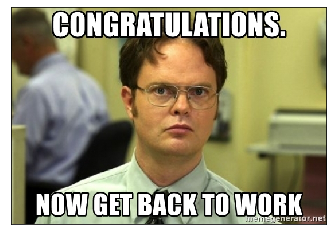

In [5]:
# This test should pass
f    = lambda x: 0.5*x.T@x
grad = lambda x: x
x = randn(10,1)
did_pass = check_gradient(f, grad, x)
assert did_pass, "Test should have passed, but failed"
# This test should fail
grad = lambda x: x+1e-5
did_pass = check_gradient(f, grad, x)
assert not did_pass, "Test should have failed, but passed"

print("Tests passed!  Your gradient checker is like totally awesome!")
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/congrats_work.png")

## Problem 2 - Logistic regression
Write a routine that evaluates the logistic loss function
$$L(z) = \sum_i \ln(1+e^{-z_i}).$$
Then, write a routine for evaluating the logistic regression objective function
$$f(w) = L(YXw)$$
where $Y$ is a diagonal matrix of labels, $X$ is matrix of training data, and $w$ is the slope vector.

Your implementation must satisfy these criteria:

-  You cannot use ANY `for` loops, or any other loops.
-  You may not explicitly form the matrix $Y.$ You may only store the vector $y.$ 
-  You can **never** exponentiate a positive number.  In other words, you can't evaluate $e^z$ for $z>0.$   Computing $e^z$ is dangerous because you get `NaN` when $z$ is big, and this will crash your code. 
-  Your `logistic_loss` routine can be at most 6 (short) lines of code (excluding return line and signature).
-  Your `logreg_objective` can be at most 2 (short) lines of code.

In [6]:
def logistic_loss(z):
    """Return sum(log(1+exp(-z))). Your implementation can NEVER exponentiate a positive number.  No for loops."""
    loss = zeros(z.shape)
    loss[z>=0] = log(1+exp(-z[z>=0]))
    # Make sure we only evaluate exponential on negative numbers
    loss[z<0] = -z[z<0]+log(1+exp(z[z<0]))
    return np.sum(loss)

def logreg_objective(w,X,y):
    """Evaluate the logistic regression loss function on the data and labels, where the rows of D contain 
    feature vectors, and y is a 1D vector of +1/-1 labels."""
    z = y*(X@w)
    return logistic_loss(z)

**Now run this unit test...**

Test PASSED!  Your logistic loss works!


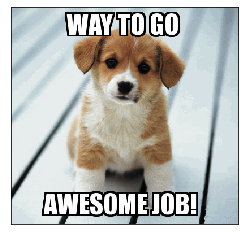

In [7]:
# Test logistic_loss using a for loop implementation
X, Y = create_classification_problem(100, 10, 10)
w = randn(10,1)
output = logreg_objective(w,X,Y)
loss = 0
for x,y in zip(X,Y):
    z = y*(x@w)
    loss += log(1+exp(-z))
assert abs(output-loss)<1e-10, 'Test FAILED:  your loss is incorrect'

output = logreg_objective(1e9*w,X,Y)
assert np.isfinite(output), "Test FAILED:  Your routine is not numerically stable.  Maybe you exponentiated a positive number?"

print('Test PASSED!  Your logistic loss works!')
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/dog.png")

**Now write a routine that produces the gradient of the logistic loss, and logistic objective.**  No `for` loops.  These routines should be short.  Remember, don't exponentiate a positive number.

In [8]:
def logistic_loss_grad(z):
    """Gradient of logistic loss"""
    grad = zeros(z.shape)
    neg = z.ravel() <=0
    pos = z.ravel() > 0
    grad[neg] = -1/(1+exp(z[neg]))
    grad[pos] = -exp(-z[pos])/(1+exp(-z[pos]))
    return grad

def logreg_objective_grad(w,X,y):
    return X.T@(y*logistic_loss_grad(y*X@w))

**Run this routine to check that your gradients are correct.**

Min relative error = 7.0931e-12
Min relative error = 2.332e-12
Tests passed!  Your logistic gradients are perfect!


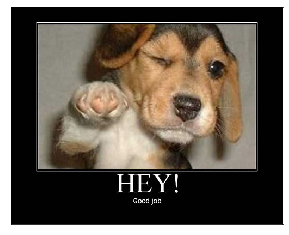

In [9]:
# Test the logistic gradient accuracy
z = randn(10,1)
did_pass = check_gradient(logistic_loss, logistic_loss_grad, z)
assert did_pass, "Incorrect gradient for logistic_loss"

# Test the logistic gradient stability
lossgrad = logistic_loss_grad(z*1e9)
assert np.alltrue(np.isfinite(lossgrad)), "FAILED: Logistic gradient is unstable.  Did you exponentiate a positive number?"

# Test the logreg objective gradient accuracy
X, y = create_classification_problem(100, 10, 10)
f = lambda w: logreg_objective(w,X,y)
grad = lambda w: logreg_objective_grad(w,X,y)
w = randn(10,1)
did_pass = check_gradient(f, grad, w)
assert did_pass, "Incorrect gradient for logistic_loss"

print("Tests passed!  Your logistic gradients are perfect!")
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/hey.png")

## Problem 3 - TV
Implement the total-variation denoising objective
$$\mu |\nabla_d x| + \frac{1}{2}\|x-b\|^2$$
where $\mu$ is an arbitrary scalar, $\nabla_d$ denotes the discrete 2d gradient, and $b$ is a noisy image.  The symbol $\nabla_d$ is the discrete 2D gradient operator, and produces all the first-order differences between adjacent pixels.

Because the $\ell_1$ norm is non-differentiable, replace it with it's hyperbolic regularization $|z| \approx \sum_i\sqrt{z_i^2+\epsilon^2}.$ 

You must use the grad2d routine from Homework 2.  It was imported by the first code cell in this assignment.

In [10]:
def h(z, eps=.01):
    """The hyperbolic approximation to L1"""
    return sum(sqrt(z*z+eps*eps))

def tv_denoise_objective(x,mu,b):
    return mu*h(grad2d(x)) + 0.5*norm(x-b)**2


**Now run this routine to check that your method runs**

In [11]:
# Create a simple test image
b = zeros((100,100))
b[25:75,25:75] = 2
x = zeros((100,100))
mu = 1
# Evaluate the loss
tvobj = tv_denoise_objective(x,mu,b)
assert tvobj==5200.0, "FAILED!  Your TV objective is incorrect."
print('Test PASSED!')

Test PASSED!


**Now implement these gradient routines.**  Use the divergence2d method from Homework 2. Each routine should be a few lines of code (in my solution each routine is only 1 line).

In [12]:
def h_grad(z, eps=.01):
    """The gradient of h"""
    return z/sqrt(z*z+eps*eps)

def tv_denoise_grad(x,mu,b):
    """The gradient of the TV objective"""
    return mu*divergence2d(h_grad(grad2d(x))) + x-b

**Now run these unit tests**

Min relative error = 6.9648e-09


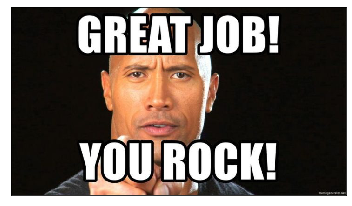

In [13]:
b = randn(100,100)
x = randn(100,100)
mu = 1
f = lambda x: tv_denoise_objective(x,mu,b)
grad = lambda x: tv_denoise_grad(x,mu,b)
did_pass = check_gradient(f,grad,x)
assert did_pass, "FAILED:  Your gradient operator is no good"

good_job("https://www.cs.umd.edu/~tomg/img/important_memes/you_rock.png")